In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


def collect_data(path, hearts, n_radial, n_angular, node_step):
    collected_data = [[], []]
    
    for heart, _ in hearts.items():
        path_ = path_stats.joinpath(heart, 'Stats')
        files = list(path_.glob('*{}'.format('.pkl')))
        files = sorted([file.stem for file in files if not file.name.startswith('.')])
    
        for slice_name in tqdm(files):
            # Load slice and build HeartSlice object
            heart_slice_builder = HeartSliceBuilder()
            heart_slice_builder.build_from_file(path, heart, slice_name,
                                                n_angular, n_radial, node_step)
            heart_slice = heart_slice_builder.heart_slice
    
            # Load stats
            for i, subdir in enumerate(['Stats', 'StatsGenerated']):
                path_slice_stats = path_stats.joinpath(heart, subdir, slice_name)
                stats_loader = StatsLoader(path_stats)
                object_stats = stats_loader.load_slice_data(path_slice_stats)
        
                # Build objects properties
                objects_props_builder = ObjectsPropertiesBuilder()
                objects_props_builder.build_from_stats(object_stats)
                objects_props_builder.add_slice_props(heart_slice)
                objects_props = objects_props_builder.objects_props
                objects_props = objects_props.loc[:, ['segment_labels',
                                                      'relative_orientation',
                                                      'axis_ratio',
                                                      'area', 'density']]
        
                objects_props['location'] = pd.cut(objects_props['segment_labels'],
                                                   bins=np.linspace(0, n_angular * n_radial,
                                                                    n_radial + 1),
                                                   labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
                objects_props['heart'] = heart
        
                collected_data[i].append(objects_props)
    
    df = pd.concat(collected_data[0], ignore_index=True)
    df_gen = pd.concat(collected_data[1], ignore_index=True)
    return df, df_gen

In [2]:
# path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

hearts = {'E10691_RBM20': 'A', 'E11444_LMNA': 'B', 'E10927_MYBPC3': 'C'}

n_radial = 3
n_angular = 12
node_step = 3


df, df_gen = collect_data(path, hearts, n_radial, n_angular, node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

### Size distribution

In [18]:
import numpy as np
from scipy import stats


class PointDensity:
    def __init__(self):
        pass

    @staticmethod
    def gaussian_kde(x, y):
        xy = np.vstack([x, y])
        density = stats.gaussian_kde(xy)(xy)
        return density

    @staticmethod
    def sort_by_density(x, y, index=False):
        density = PointDensity.gaussian_kde(x, y)
        idx = density.argsort()
        if index:
            return idx
        return idx, density[idx]


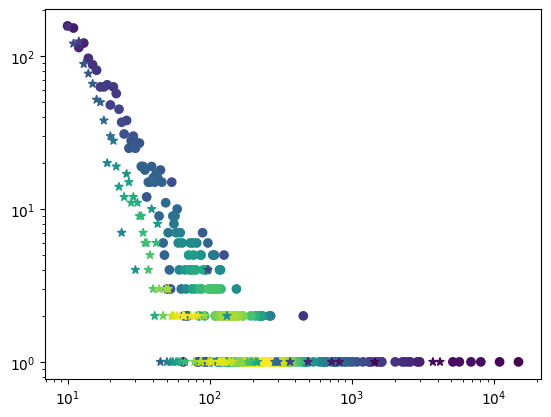

In [6]:
def calc_area_counts(df, min_dens=0., max_dens=1.):
    area = df['area'].values
    area = area[df['density'].between(min_dens, max_dens)]
    unique, counts = np.unique(area, return_counts=True)
    return unique, counts


colors = ['r', 'g', 'b']
markers = ['o', '*']
x = np.geomspace(10, 1000, 100)
plt.figure()

for i, ddf in enumerate([df, df_gen]):
    for j, (min_dens, max_dens) in enumerate(zip([0], [1.])):
        unique, counts = calc_area_counts(ddf, min_dens, max_dens)
        
        pdens = PointDensity.gaussian_kde(np.log(unique), np.log(counts))
        idx = pdens.argsort()
        
        plt.scatter(unique[idx], counts[idx], c=pdens[idx], 
                    marker=markers[i])
# plt.plot(x, np.power(x, -1.))
plt.yscale('log')
plt.xscale('log')
plt.show()

### Elongation

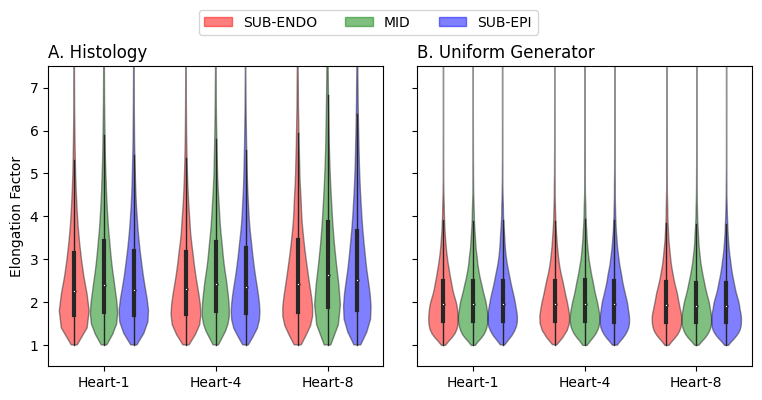

In [3]:
import seaborn as sns
import matplotlib.patches as mpatches

COLORS = {'SUB-ENDO': 'r', 'MID': 'g', 'SUB-EPI': 'b'}

fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for ddf, ax in zip([df, df_gen], axs):
    sns.violinplot(data=ddf, y='axis_ratio', x='heart', hue='location', 
                   ax=ax, palette=COLORS, alpha=0.5, saturation=1,
                  linewidth=1, legend=False, cut=0)


for ax in axs:
    for violin in ax.collections[::2]:
        violin.set_alpha(0.5)
    ax.set_xticks(ticks=[0, 1, 2], labels=['Heart-1', 'Heart-4', 'Heart-8'])
    ax.set_xlabel('')

    ax.set_ylim(0.5, 7.5)
    ax.get_legend().remove()
axs[1].set_ylabel('')
axs[0].set_ylabel('Elongation Factor')

plt.subplots_adjust(top=0.85, bottom=0.1, right=0.98, left=0.1,
                    wspace=0.1, hspace=0.2)

legends = [mpatches.Patch(color=color, label=label,
                          alpha=0.5) for label, color in COLORS.items()]
fig.legend(handles=legends, labels=list(COLORS.keys()), loc='center',
           bbox_to_anchor=(0.5, 0.96), ncol=3)
# fig.legend(handles=bar_gen.patches[:1] + bar.patches[:1],
#            labels=['Uniform generator', 'Histology'], loc='center',
#            bbox_to_anchor=(0.5, 0.96), ncol=2)
axs[0].set_title('A. Histology', loc='left')
axs[1].set_title('B. Uniform Generator', loc='left')
plt.show()

In [4]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('axis_ratio.png'),
            dpi=300, bbox_inches='tight')

In [115]:
grouped = df_gen.groupby(['heart', 'location'], observed=True)
grouped['axis_ratio'].describe()

count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  43572.0  2.112152  0.771067  1.000000  1.546028   
              MID       42764.0  2.119858  0.783533  1.000000  1.552786   
              SUB-EPI   26394.0  2.114921  0.766919  1.000000  1.552011   
E10927_MYBPC3 SUB-ENDO  43611.0  2.093616  0.760115  1.000000  1.538261   
              MID       58489.0  2.074574  0.738599  1.001837  1.530629   
              SUB-EPI   60110.0  2.077907  0.747669  1.000000  1.528277   
E11444_LMNA   SUB-ENDO  38555.0  2.108122  0.766516  1.004796  1.549672   
              MID       32350.0  2.123689  0.784082  1.000000  1.553101   
              SUB-EPI   24572.0  2.105220  0.759022  1.004988  1.542345   

                             50%       75%        max  
heart         location                                 
E10691_RBM20  SUB-ENDO  1.943963  2.496595  10.148495  
              MID       1.948644  2.491018   9.469669  
              SUB-EPI   1.952163  2.494479  11.489125  
E10927_MYBPC3 SUB-ENDO  1.927998  2.462107   9.281975  
              MID       1.916600  2.444283   9.281975  
              SUB-EPI   1.915523  2.447636   8.136683  
E11444_LMNA   SUB-ENDO  1.945455  2.481833  17.372327  
              MID       1.952151  2.505362  10.148495  
              SUB-EPI   1.945994  2.495178   9.281975

In [132]:
grouped = df.groupby(['heart', 'location'], observed=True)
grouped['relative_orientation'].describe()

count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  60525.0 -0.106220  0.845081 -1.570784 -0.781425   
              MID       77345.0 -0.051019  0.675346 -1.570678 -0.470271   
              SUB-EPI   55844.0 -0.025309  0.820606 -1.570780 -0.654581   
E10927_MYBPC3 SUB-ENDO  24848.0 -0.020822  0.869688 -1.570457 -0.748082   
              MID       28573.0 -0.018454  0.711428 -1.570698 -0.498624   
              SUB-EPI   38058.0  0.054356  0.799535 -1.570704 -0.533492   
E11444_LMNA   SUB-ENDO  34026.0 -0.065898  0.926751 -1.570730 -0.881197   
              MID       43254.0  0.003792  0.736936 -1.570792 -0.488526   
              SUB-EPI   40524.0  0.033861  0.859528 -1.570707 -0.641514   

                             50%       75%       max  
heart         location                                
E10691_RBM20  SUB-ENDO -0.173006  0.528399  1.570602  
              MID      -0.044195  0.340106  1.570751  
              SUB-EPI  -0.022618  0.573735  1.570678  
E10927_MYBPC3 SUB-ENDO -0.031257  0.696356  1.570668  
              MID      -0.017653  0.447560  1.570622  
              SUB-EPI   0.080571  0.665077  1.570394  
E11444_LMNA   SUB-ENDO -0.126071  0.748027  1.570761  
              MID       0.013096  0.494562  1.570286  
              SUB-EPI   0.050411  0.725165  1.570746

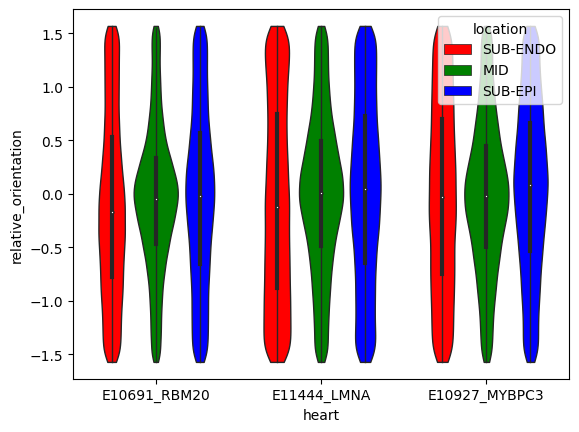

In [11]:
fig, ax = plt.subplots()
sns.violinplot(data=df, y='relative_orientation', x='heart', hue='location', 
               ax=ax, palette=COLORS, alpha=0.5, saturation=1,
               linewidth=1, legend=False, cut=0)
plt.show()

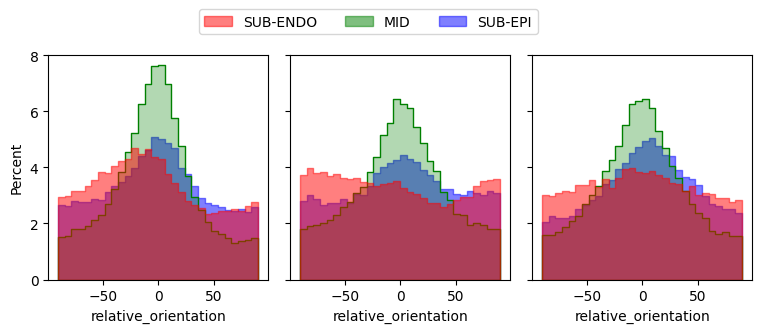

In [39]:
fig, axs = plt.subplots(ncols=3, figsize=(8, 3), sharex=True, sharey=True)

for i, (heart, _) in enumerate(hearts.items()):
    ddf = df[df['heart'] == heart]
    
    x = ddf['relative_orientation'].apply(np.degrees)

    sns.histplot(data=ddf, x=x, hue='location', element="step",
                 bins=np.linspace(-90, 90, 31), palette=COLORS, alpha=0.3,
                 ax=axs[i], linewidth=1, stat='percent', common_norm=False)
    

for ax in axs:
    for hist in ax.collections[::2]:
        hist.set_alpha(0.5)
#     ax.set_xticks(ticks=[0, 1, 2], labels=['Heart-1', 'Heart-4', 'Heart-8'])
#     ax.set_xlabel('')

#     ax.set_ylim(0.5, 7.5)
    ax.get_legend().remove()
axs[1].set_ylabel('')
# axs[0].set_ylabel('Elongation Factor')

plt.subplots_adjust(top=0.85, bottom=0.1, right=0.98, left=0.1,
                    wspace=0.1, hspace=0.2)

legends = [mpatches.Patch(color=color, label=label,
                          alpha=0.5) for label, color in COLORS.items()]
fig.legend(handles=legends, labels=list(COLORS.keys()), loc='center',
           bbox_to_anchor=(0.5, 0.96), ncol=3)
plt.show()

In [29]:
df.groupby(['heart', 'location'])['relative_orientation'].describe()


count      mean       std       min       25%  \
heart         location                                                    
E10691_RBM20  SUB-ENDO  60525.0 -0.106220  0.845081 -1.570784 -0.781425   
              MID       77345.0 -0.051019  0.675346 -1.570678 -0.470271   
              SUB-EPI   55844.0 -0.025309  0.820606 -1.570780 -0.654581   
E10927_MYBPC3 SUB-ENDO  24848.0 -0.020822  0.869688 -1.570457 -0.748082   
              MID       28573.0 -0.018454  0.711428 -1.570698 -0.498624   
              SUB-EPI   38058.0  0.054356  0.799535 -1.570704 -0.533492   
E11444_LMNA   SUB-ENDO  34026.0 -0.065898  0.926751 -1.570730 -0.881197   
              MID       43254.0  0.003792  0.736936 -1.570792 -0.488526   
              SUB-EPI   40524.0  0.033861  0.859528 -1.570707 -0.641514   

                             50%       75%       max  
heart         location                                
E10691_RBM20  SUB-ENDO -0.173006  0.528399  1.570602  
              MID      -0.044195  0.340106  1.570751  
              SUB-EPI  -0.022618  0.573735  1.570678  
E10927_MYBPC3 SUB-ENDO -0.031257  0.696356  1.570668  
              MID      -0.017653  0.447560  1.570622  
              SUB-EPI   0.080571  0.665077  1.570394  
E11444_LMNA   SUB-ENDO -0.126071  0.748027  1.570761  
              MID       0.013096  0.494562  1.570286  
              SUB-EPI   0.050411  0.725165  1.570746